In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.000001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
        all_dfs1 = pd.concat(dfs1) 
        preds, labs = all_dfs1['pred'], all_dfs1['label']
        xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
        r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
        
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
        df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)

    return r2_val, df_fin 

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_neg_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [('-', inp), '=']
        trial.append(-1*cue_dict[inp])
        seq.append(trial)
    return seq

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

# RNN setup

In [3]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1000
num_sims = 48
num_inputs = 5

In [27]:
## running function

def run_exp(trainseqs_old, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())[1:]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_plot(trainseqs, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    tests = [r['test'] for r in res]

    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc': acc_test[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc = fully_trained['test_acc'].mean() 
    fully_trained_test_acc_std = fully_trained['test_acc'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests = [tests[i] for i in fully_trained_idx]
    if len(ft_mods) > 0:
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests)
    else:
        r2, dfs, alldfs = 0, 0, 0

    t3 = time.time()
    print('total time: ', (t3-t1)/60)
    print(fully_trained.shape[0], '/', final_accs.shape[0], ' rnns trained to 100% accuracy.\
        \n Mean test acc = ', round(fully_trained_test_acc, 2),  '\n-----------\n')

    return dfs


# Experiments

Final accuracy against ratio of other/self



## Num inputs = 5

In [24]:
ops = ['+']
num_inputs = 3
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
print(cue_dict)

{'A': 10, 'B': 17, 'C': 14}


In [25]:
# 1: all self
ops = '-'
p = generate_primitives(all_syms)
p_neg = generate_neg_primitives(all_syms)
train_other = generate_trials(ops, all_syms[1:], all_syms[1:])
trainseqs = train_other + p + p_neg
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [t for t in testseqs if t not in trainseqs] 
print(trainseqs)

[['B', ('-', 'B'), '=', 17], ['B', ('-', 'C'), '=', 17], ['C', ('-', 'B'), '=', 14], ['C', ('-', 'C'), '=', 14], ['A', '=', 10], ['B', '=', 17], ['C', '=', 14], [('-', 'A'), '=', -10], [('-', 'B'), '=', -17], [('-', 'C'), '=', -14]]


# Xavier normal

In [28]:
hidden_size=30
num_sims = 8

run time:  0.5640810052553813
2


ValueError: not enough values to unpack (expected 3, got 2)

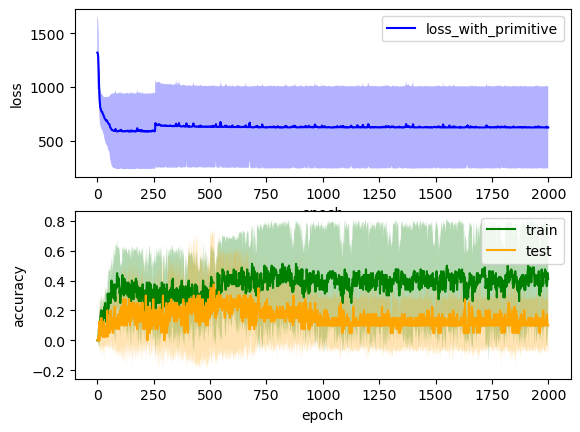

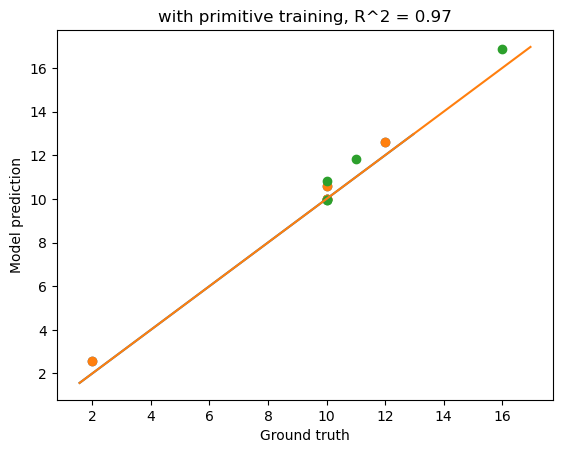

In [29]:
# gain = 0.001
epochs = 2000
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)

r = run_plot(trainseqs, testseqs, cue_dict)

In [ ]:
# gain = 0.00001
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.00001)

r = run_plot(trainseqs, testseqs)

run time:  1.2043317675590515


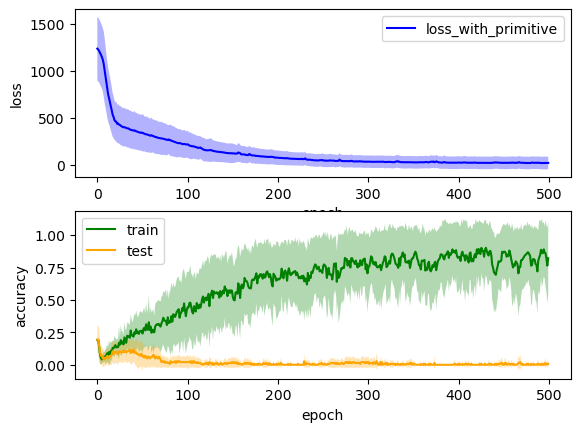

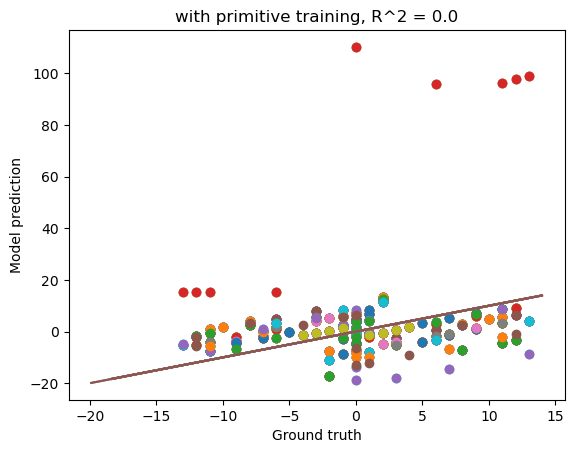

In [39]:
# gain = 0.0000001
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.0000001)

r = run_plot(trainseqs, testseqs)

run time:  1.237133554617564


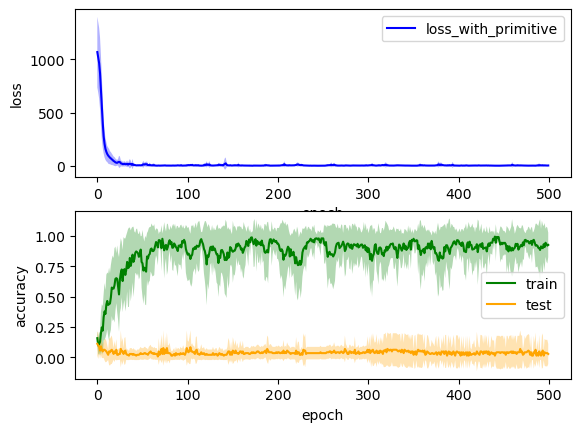

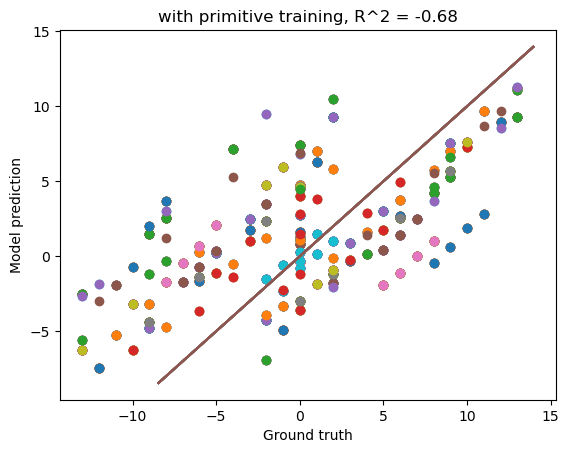

In [40]:
## Kaiming
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

r = run_plot(trainseqs, testseqs)

run time:  1.274344265460968


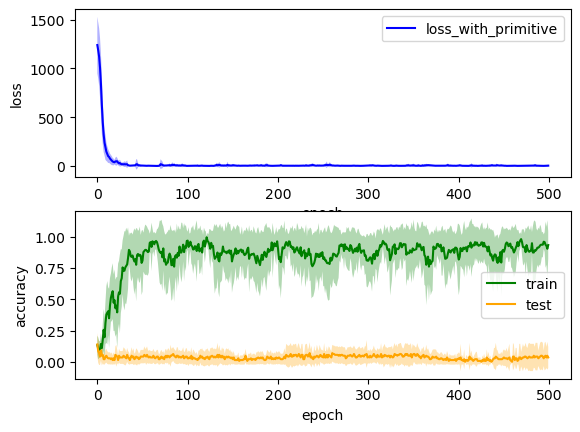

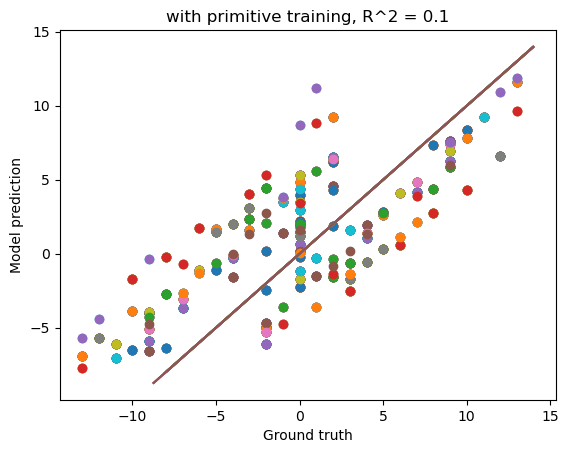

In [42]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, 0.001)

r = run_plot(trainseqs, testseqs)

run time:  1.3119596481323241


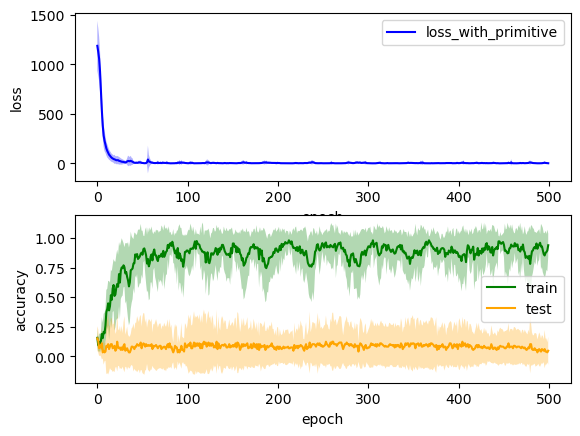

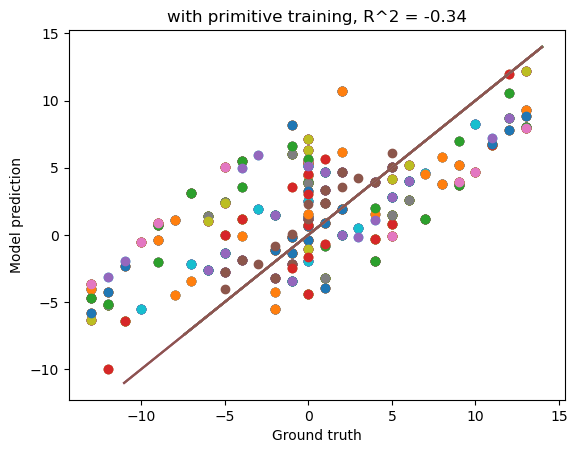

In [43]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

r = run_plot(trainseqs, testseqs)

run time:  1.0337097684542338


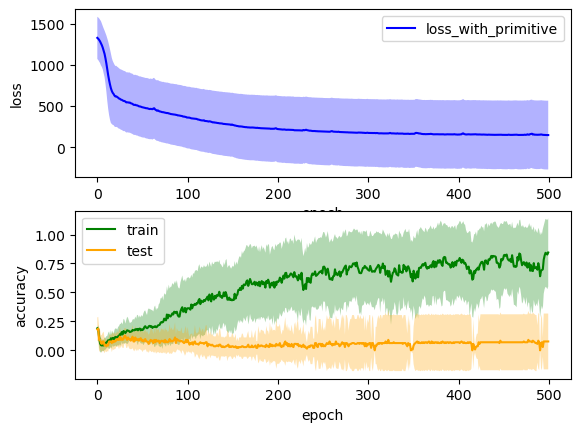

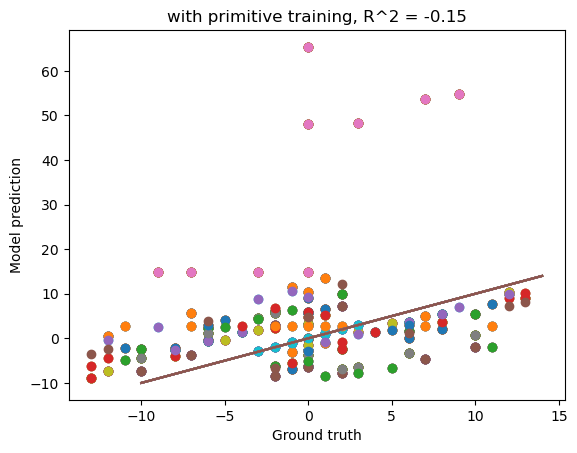

In [48]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, 0.00001)

r, m = run_plot(trainseqs, testseqs)

In [59]:
num_sims=64

In [ ]:
# New architecture

In [60]:
hidden_size = 40

run time:  4.970931649208069


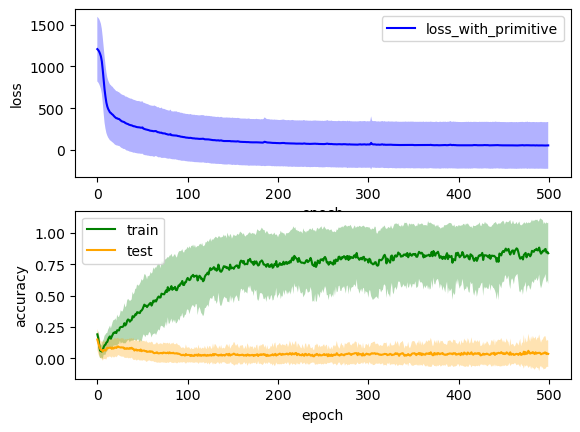

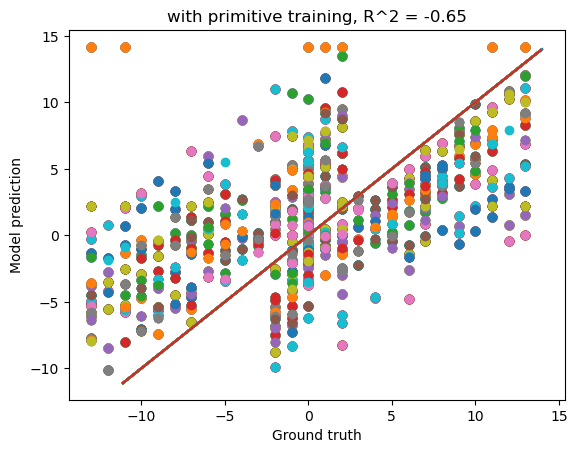

In [61]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.00001)

r = run_plot(trainseqs, testseqs)

In [62]:
hidden_size = 20
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.00001)

r = run_plot(trainseqs, testseqs)

KeyboardInterrupt: 

In [54]:
rnn.state_dict()

OrderedDict([('rnn.weight_ih_l0',
              tensor([[ 1.1920e-01,  1.5244e-02, -1.9088e-01,  1.4039e-01, -5.6162e-02,
                        1.4399e-01, -7.1005e-02,  4.4731e-02, -1.3141e-02,  2.0789e-01,
                        1.9277e-01,  6.2100e-02, -2.9090e-02, -1.1023e-01, -4.3542e-02,
                       -7.6601e-02,  4.2274e-02, -9.1430e-02, -1.6247e-01,  1.9453e-01,
                       -2.2333e-02,  9.9079e-02],
                      [-3.6049e-02,  2.6323e-02, -1.2674e-01, -6.4476e-02, -1.1394e-01,
                        1.1688e-04,  1.6237e-01,  2.0257e-01,  5.1120e-02, -1.6201e-01,
                        1.3564e-01, -3.2255e-02,  4.9642e-02,  4.2422e-02, -1.6732e-01,
                       -2.6807e-02,  7.6604e-03, -6.8944e-02, -1.5739e-01, -1.7660e-01,
                        4.8077e-02, -9.1242e-03],
                      [-1.9936e-01, -1.2248e-01, -1.9186e-01,  1.7519e-01, -2.0314e-02,
                        2.0409e-03,  7.8509e-02, -1.4006e-01, -3.2924e-02,

In [41]:
num_layers

1

In [18]:
num_layers = 2

run time:  1.2097424030303956


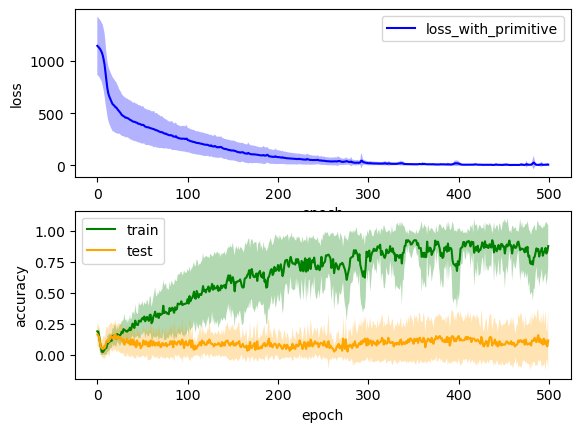

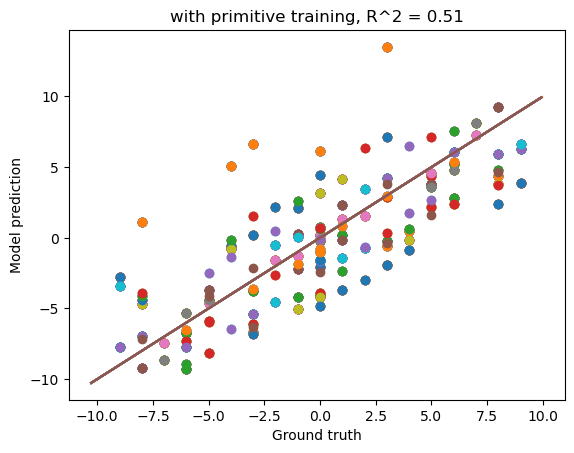

In [19]:
# gain = 0.00001
num_sims=16
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.00001)

r = run_plot(trainseqs, testseqs)

In [31]:
hidden_size = 20
num_layers = 1

run time:  2.5415536840756734


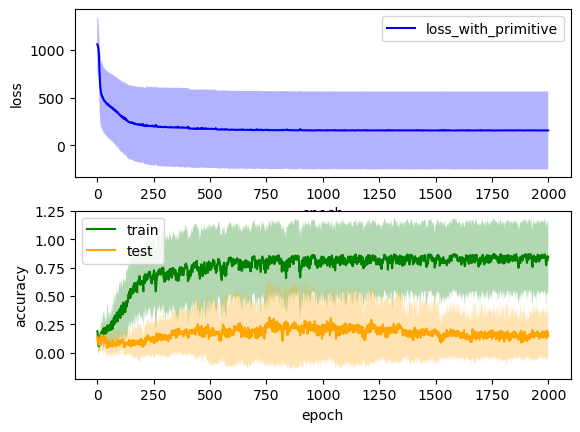

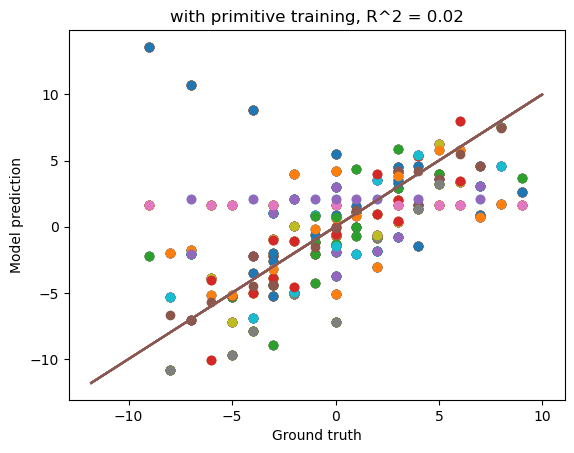

In [32]:
# gain = 0.00001
num_sims=16
epochs = 2000
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.00001)

r = run_plot(trainseqs, testseqs)

In [ ]:
#[ -1/sqrt(n), 1/sqrt(n)]

In [ ]:
## working out iterative script

In [ ]:
num_self = 5
num_other = 

5